# Welcome to assignment 1! 👏👏

The exercise's objectives are the following:

1.   Understand the algorithms you learned in class.
2.   Learn how to write code in Python and how to use Google Colab.
3.   Have fun!


# Google Colab
Colaboratory, or “Colab” for short, is a product from Google Research. Colab allows anybody to write and execute arbitrary python code through the browser, and is especially well suited to AI, machine learning, data analysis and education. More technically, Colab is a hosted Jupyter notebook service that requires no setup to use, while providing free access to computing resources including GPUs.


It is recommended to go through this [guide](https://www.datacamp.com/tutorial/tutorial-google-colab-for-data-scientists)
 before starting.


**Important tip:** If the same variable name appears in two different cells, the variable value will be determined by the last cell to run, rather than by the position of the cell. Let's see an example,  run the three cells below:

In [1]:
# cell 1
x = 3

In [2]:
# cell 2
x = 5

In [3]:
print(x)

5


now rerun cell 1 and print x again.

The same applies to functions, classes, etc.


To work with colab, save the assignment in a folder in Google Drive. Match the following two lines in the cell below with the location in which folder has been saved and run the cell.


1.   !cp -r /content/drive/MyDrive/ "**path to the folder**" /* .
2.   sys.path.append('/content/drive/MyDrive/ "**path to folder**" /FrozenKaleEnv.py')

After running the cell below with the right path, you should see the contents of the assignment folder in the left-hand bar, under "Files".


In [4]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)

### Lior
#!cp -r /content/drive/MyDrive/AI-assignment1/* . #line 1
#sys.path.append('/content/drive/MyDrive/AI-assignment1/FrozenKaleEnv.py') # line 2

### Yotam
!cp -r /content/drive/MyDrive/Technion/'2022 23'/'Winter 2022'/'Intro. to AI'/Homework/'HW#1'/* . #line 1
sys.path.append('/content/FrozenLakeEnv.py') # line 2

Mounted at /content/drive


# Getting started with Open AI gym

[OpenAI Gym](http://gym.openai.com) is a toolkit for comparing AI and RL algorithms. It contains a wide variety of environments that you can train your agents on, and it is often used for benchmarking new methods in the AI research literature. 
There are also [leaderboards](https://github.com/openai/gym/wiki/Leaderboard) for different gym-environments, showing which methods have been most successful so far.

In this assignments we will use OpenAI gym (within the course's scope).



# The Environment
You will work on a custom version of the [Frozen Lake](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) environment from OpenAI.

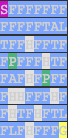

1. Your goal is to find a route from the top left corner to the bottom right corner.
2. Each position on the map is marked with a letter, and each letter has a different meaning:

  *   S - Initial (start) position. There's only one initial state on the map and it's always at the upper left corner.
  *   G - Final state. There's only one final state on the map and it's always in the lower right corner.
  *   H - Hole. When your agent reachs a hole, it falls into the water and cannot continue walking.
  *   P -  Portal. There are either two or zero portals on the map. When the agent reaches a portal, it is immediately transported to the other portal. You can assume that they will not appear in a final or initial state.
  *   F -  Frozen lake. This is the most common square on the map. The agent can walk on it safely.

  Your agent can move faster by collecting 3 special objects.

  *   T - [Talaria](https://en.wikipedia.org/wiki/Talaria). A pair of Winged Sandals that help you fly to the square.
  *   A - Air jorden. Jumping shoes that help you jump to the square.
  *   L - Lightning. Makes you run faster to the square.

  When the agent performs transition (s,a,s') and collects one of the objects (T,A,L) at state s', the collected object changes the cost of the transition (as detailed below). 

3. The cost of each transition (s,a,s') is based on the mark if the square s' you pass to:
  * S - 1
  * G - 1
  * H - 0
  * P - 100
  * F - 10
  * T - 3
  * A - 2
  * L - 1

4. The pink square marks where your agent is.

5. The number of states is equal to the number of squares on the map. The state index is calculated as follows: row_number *num_col + col_ number*. For example, the state index of the portal squere on row 3 is : 3 * 8 + 1 = 25.

6. Our agent can perform 4 actions:
  * 0 - Down
  * 1 - Right
  * 2 - Up
  * 3 - Left
  

7. If the agent tries to move outside the board boundaries, he stays in the same place.

8. Section 6 describes the order in which the nodes should be created.



In [5]:
import time
from IPython.display import clear_output

import numpy as np

import gym
from gym import Env, logger, spaces, utils
from gym.envs.toy_text.utils import categorical_sample
from gym.error import DependencyNotInstalled

from FrozenLakeEnv import FrozenLakeEnv
from typing import List, Tuple
import heapdict



In [6]:
DOWN = 0
RIGHT = 1
UP = 2
LEFT = 3

# Maps
A map can be produced manually as shown in the cell below. We will only work on maps in which there is a route from the initial state to the final state.

In [7]:
MAPS = {
    "5x5": ["SHLLL",
            "FHLHL",
            "FLLHL",
            "FHHHL",
            "FFFFG"],
    "4x4": ["SFFF",
            "FHFH",
            "FFFH",
            "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFTAL",
        "TFFHFFTF",
        "FPFFFHTF",
        "FAFHFPFF",
        "FHHFFFHF",
        "FHTFHFTL",
        "FLFHFFFG"]
}


# The Frozen Lake Environment ⛷
The file `FrozenLakeEnv.py` implements our own version of the frozen lake environment. It is recommended to go through the code. 

**Note: You are not allowed to change this file.**

Lets start by creating a new environment object.

In order to create an environment object, you must provide it with a board.

In [8]:
env = FrozenLakeEnv(MAPS["8x8"])
state = env.reset()
print('Initial state:', state)    

Initial state: 0


First, take a look at the state space $\mathcal{S}$ (all possible states) and action space $\mathcal{A}$ (all possible actions). 

In [9]:
print(f"Action Space {env.action_space}")
print(f"State Space {env.observation_space}")

Action Space Discrete(4)
State Space Discrete(64)


***Remark***: You may have noticed that gym uses `observation_space` instead of state space. For the purpose of this homework, the state space is the same as the observations space. However, in some problems the full state cannot be observed, so the space of possible states may not be the same as the space of possible observations. 



Now we will go throught some usfel methods (It is still recommended to go through the other methods in the class):

`render()` - returns a printable view of the board.

In [10]:
print(env.render())


SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG



The pink square represents the agent. The letter ״*H*״ represents holes, and the yellow square is the final state.

Here are two more useful methods:

`get_state()` - Returns the current state of the agent.

`set_state(state)` - Sets the current state of the agent.

In [11]:
env.set_state(18)
print(env.render())
print(f"the agent is at state: {env.get_state()}")


SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

the agent is at state: 18


`succ(state)` - Returns a dictionary that contains information on all the successors of a state.

*   The keys are the actions.
*   The values are tuples of the form (next state, cost, terminated). Note that terminated is true when the agent reaches a **final state** or a **hole**.



***Tip***: You can loop through both keys and values by using the `items()` method.


In [12]:
current_state = env.get_state()
print(f"Current state: {current_state}\n")
for action, successor in env.succ(current_state).items():
  print(f"*** Action: {action} ***")
  print(f"Next state: {successor[0]}")
  print(f"Cost: {successor[1]}")
  print(f"Terminated: {successor[2]}\n")

Current state: 18

*** Action: 0 ***
Next state: 26
Cost: 10.0
Terminated: False

*** Action: 1 ***
Next state: 19
Cost: 0.0
Terminated: True

*** Action: 2 ***
Next state: 10
Cost: 10.0
Terminated: False

*** Action: 3 ***
Next state: 17
Cost: 10.0
Terminated: False



As you can see, the action 0 (down) will move your agent to state 26 and the transition will cost you 10. Action 1 will move your agent to state 19, which is a hole that will terminate your run.

`is_final_state(state)` can assist you in distinguishing between a final state and a hole.

In [13]:
state, cost, terminated = env.succ(current_state)[1]

print(f"Next state: {state}")
print(f"Cost: {cost}")
print(f"Terminated: {terminated}")
print(f"Final state: {env.is_final_state(state)}")

Next state: 19
Cost: 0.0
Terminated: True
Final state: False


Let's see what happens when we apply succ(state) on a hole:



In [14]:
print(f"Current state: 19\n")
for action, successor in env.succ(19).items():
  print(f"*** Action: {action} ***")
  print(f"Next state: {successor[0]}")
  print(f"Cost: {successor[1]}")
  print(f"Terminated: {successor[2]}\n")

Current state: 19

*** Action: 0 ***
Next state: None
Cost: None
Terminated: None

*** Action: 1 ***
Next state: None
Cost: None
Terminated: None

*** Action: 2 ***
Next state: None
Cost: None
Terminated: None

*** Action: 3 ***
Next state: None
Cost: None
Terminated: None



As you can see, if the operator cannot be applied to the state, all returned values are "None"

Now it's time to move your agent around 🤖.

`step(action)` - will move your agent one step along the board.


In [15]:
new_state, cost, terminated = env.step(DOWN)
print(env.render())
print("New state:", new_state)
print("cost:", cost)
print("Terminated:", terminated)

  (Down)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

New state: 26
cost: 10.0
Terminated: False


The step-function returns the following information:
* __New state__: The state after the action is taken.
* __Cost__: The immediate cost.
* __Terminated__: Is the environment done? In our environment this will be false until the agent will reach a hole or a final state.

Let's move your agent one step left towards the portal and see what happens.

In [16]:
new_state, cost, done = env.step(LEFT)
print(env.render())
print("New state:", new_state)
print("cost:", cost)
print("Done:", done)

  (Left)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

New state: 37
cost: 100
Done: False


Have you noticed that your agent has moved to the second portal😲?

On some maps, the portals can significantly shorten your route, but going through them is much more expensive, so it is not always advisable.


Here are a few more useful attributes and methods:


`env.nrow`, `env.ncol` - Row and columns number.

`env.nA` - Number of actions.

`env.nS` - Number of states.

`env.lastaction` - The last action performed by the agent.

`env.p1`, `env.p2` - This is the state number for each portal. If there are no portals on the board they are set to NULL.

`env.inc(row, col, action)` - Given a position and an action, returns the new position.

`env.to_row_col(state)` - Converts between state and location on the board.

`env.to_state(row, col)` - Converts between location on the board and state.



We've finished our demo 🥳 and it's time to reset the environment.

In [17]:
print(f"current state befor reset: {env.get_state()}")
env.reset()
print(f"current state after reset: {env.get_state()}")


current state befor reset: 37
current state after reset: 0


One (quite bad) strategy for out agent is to take a random action every time. Inside a gym-environment this can be done using `env.action_space.sample()`, which samples a random action from the action space. Look through the following loop and make sure that you understand what's going on. Here, we use `clear_output()` to clear the output of the Jupyter cell, and `time.sleep()` to pause between each action)


Let's see what would happen if we try to brute-force our way to solving the problem.


We'll create an infinite loop that runs until the agent reaches the final state.The `env.action_space.sample()` method automatically selects one random action from set of all possible actions.

In [18]:
class RandomAgent():
  def __init__(self):
    self.env = None

  def animation(self, epochs: int ,state: int, action: List[int], total_cost: int) -> None:
      clear_output(wait=True)
      print(self.env.render())
      print(f"Timestep: {epochs}")
      print(f"State: {state}")
      print(f"Action: {action}")
      print(f"Total Cost: {total_cost}")
      time.sleep(1)

  def random_search(self, FrozenLakeEnv: env) -> Tuple[List[int],int]:
    self.env = env
    self.env.reset()
    epochs = 0
    cost = 0
    total_cost = 0

    actions = []

    state = self.env.get_initial_state()
    while not self.env.is_final_state(state):
      action = self.env.action_space.sample()
      new_state, cost, terminated = self.env.step(action)
        
      while terminated is True and self.env.is_final_state(state) is False:
        self.env.set_state(state)
        action = self.env.action_space.sample()
        new_state, cost, terminated = self.env.step(action)
        
      actions.append(action)
      total_cost += cost
      state = new_state
      epochs += 1
      
      self.animation(epochs,state,action,total_cost)

    return (actions, total_cost)


Let's check out this agent's performance!

The output of this agent is the sequence of actions that led to the solution and the route's cost. 

Our random agent is not very successful, so we'll print his actions as they happen. 

1.   **Stop his run in the middle if you are tired of looking at him.**
2.   After watching the agent please put the code in the box below in the a comment. During testing, we do not want the notebook to get stuck in this box.

 



In [19]:
#agent = RandomAgent()
#agent.random_search(env)

**Did you remember to put the code above in a comment?!**

As you can see, a random policy is, unsurprisingly, not a good policy. However, what else can we do?

This is where you come in!

In this assignment you will be required to implement the following algorithms taught in class in order to solve the problem.

Algorithms: 
1. BFS-G
2. DFS-G
3. ID-DFS-G
4. Uniform Cost Search (UCS)
5. Greedy Best Search
6. W-A*
7. A* epsilon

Important to note!

Each agent should return a tuple: (actions, cost, expended) 
*  actions - the list of integers containing the sequence of actions that produce your agent's solution (and not the entire search process).
* cost -  an integer which holds the total cost of the solution.
* expanded - an integer which holds the number of nodes that have been expanded during the search.

The solution to our search problem is the path to the final state, not the final state itself (since it is known). By saving the actions, we are able to restore the path your agent found.


Any other output, unless otherwise specified, will cause the running of the notebook to fail and will result in a grade of 0 !




Some Tips:
1. Follow the pseudo-code shown in the lectures.
2. You should write all your code within the classes. This way, we prevent overlapping functions with the same name while running the notebook.
3. Consider implementing a "node" class.
4. Using small boards will help you debug.


The function below (`print_solution()`) can be used for debugging purposes. It prints the sequence of actions it receives. The function will not be used to test your code, so you are welcome to change it.

In [20]:
def print_solution(actions,env: FrozenLakeEnv) -> None:
    env.reset()
    total_cost = 0
    print(env.render())
    print(f"Timestep: {1}")
    print(f"State: {env.get_state()}")
    print(f"Action: {None}")
    print(f"Cost: {0}")
    time.sleep(1)

    for i, action in enumerate(actions):
      state, cost, terminated = env.step(action)
      total_cost += cost
      clear_output(wait=True)

      print(env.render())
      print(f"Timestep: {i + 2}")
      print(f"State: {state}")
      print(f"Action: {action}")
      print(f"Cost: {cost}")
      print(f"Total cost: {total_cost}")
      
      time.sleep(1)

      if terminated is True:
        break

## **Node Implementation:**

In [21]:
class Node:
  def __init__(self, env, state, action, parent, total_cost):
    self.state = state
    self.action = action
    self.env = env
    self.parent = parent
    self.total_cost = total_cost

  def __eq__(self,s):
    return self.state == s

  def __hash__(self):
    return hash(self.state)

  def expand(self):
    sons = []
    for action, successor in self.env.succ(self.state).items():
      if (successor[0] != None):
        sons.append(Node(self.env, successor[0], action, self, self.total_cost+successor[1]))
    return sons

  def path(self):
    parent_path = []
    node = self
    while node.parent != None:
      parent_path = [node.action] + parent_path
      node = node.parent
    return parent_path

class Heuristic_Node(Node):
  def __init__(self, env, state, action, parent, total_cost):
    super().__init__(env, state, action, parent, total_cost)
    self.h = self.h_sap(state)
    self.f = self.calc_f()

  def h_sap(self, state):
    row, col = self.env.to_row_col(state)
    return min(100, self.env.nrow - 1 - row + self.env.ncol - 1 - col)

  def calc_f(self):
    return self.h + self.total_cost

  def expand(self):
    sons = []
    for action, successor in self.env.succ(self.state).items():
      if (successor[0] != None):
        sons.append(Heuristic_Node(self.env, successor[0], action, self, self.total_cost+successor[1]))
    return sons

## 1. BFS-G
**TO DO:** implement Breadth First Search (BFS) algorithm on graph like shown in class.


In [22]:
class BFSAgent:
    def __init__(self):
      self.env = None

    def bfs_search(self, env: FrozenLakeEnv)-> Tuple[List[int], int, int]:
      self.env = env
      self.env.reset()
      initial = Node(env, env.get_initial_state(), None, None, 0)

      # It's given that the initial state isn't a goal state -> no need to check it like in the psuedo-code
      open = [initial]
      close = []; expanded = 0
      while len(open) != 0:
        n = open.pop(0) # FIFO queue
        env.set_state(n.state)
        close.append(n.state)
        ex = n.expand()
        expanded += 1
        for son in ex:
          if (not son.state in close) and (not son in open):
            if env.is_final_state(son.state):
              return son.path(), son.total_cost, expanded
            open.append(son)

Now lets test your BFS agent!

In [23]:
BFS_agent = BFSAgent()
actions, total_cost, expanded = BFS_agent.bfs_search(env)
print(f"Total_cost: {total_cost}")
print(f"Expanded: {expanded}")
print(f"Actions: {actions}")

Total_cost: 164.0
Expanded: 55
Actions: [0, 0, 0, 1, 0, 0, 0, 1, 1]


In [24]:
print_solution(actions, env)

  (Right)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

Timestep: 10
State: 63
Action: 1
Cost: 1.0
Total cost: 164.0


## 2. DFS-G
**TO DO:** implement Depth First Search (DFS) algorithm on graph like shown in class.


In [25]:
class DFSAgent:
  def __init__(self):
    self.env = None
  
  def dfs_search(self, env: FrozenLakeEnv)->Tuple[List[int], int, int]:
    self.result = False
    self.env = env
    self.env.reset()
    initial = Node(env, env.get_initial_state(), None, None, 0)

    # It's given that the initial state isn't a goal state -> no need to check it like in the psuedo-code
    open = [initial]
    close = []; self.expanded = 0
    path, total_cost = self.recursive_dfs(open, close)
    return path, total_cost, self.expanded

  def recursive_dfs(self, open, close):
    env = self.env
    n = open.pop(len(open)-1) # LIFO queue
    env.set_state(n.state)
    close.append(n.state)
    
    # base case
    if env.is_final_state(n.state):
      self.result = True
      return n.path(), n.total_cost
    
    ex = n.expand()
    self.expanded += 1
    # recursive steps
    for son in ex:
      if (not son.state in close) and (not son in open) and self.result==False:
        open.append(son)
        path, total_cost = self.recursive_dfs(open, close)  
      if self.result != False:
        return path, total_cost
        
    return None, None

Now lets test your DFS agent!

In [26]:
DFS_agent = DFSAgent()
actions, total_cost, expanded = DFS_agent.dfs_search(env)
print(f"Total_cost: {total_cost}")
print(f"Expanded: {expanded}")
print(f"Actions: {actions}")

Total_cost: 148.0
Expanded: 20
Actions: [0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 1, 1, 0, 0, 1, 1]


In [27]:
print_solution(actions, env)

  (Right)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

Timestep: 19
State: 63
Action: 1
Cost: 1.0
Total cost: 148.0


## 3. ID-DFS-G
**TO DO:** implement Iterative Deepening Depth First Search (ID-DFS) like shown in class. 


To find a solution, your agent needs to run the DFS-L-G (on graph) algorithm and go one step deeper with each iteration. You can assume that your code will not be interrupted in the middle of its execution. Thus, your agent should continue searching for a solution until a solution is found.


In [28]:
class IDDFSAgent:
    def __init__(self):
        self.env = None
        
    class DFSLAgent:
      def __init__(self):
        self.env = None
  
      def dfsl_search(self, env: FrozenLakeEnv, l)->Tuple[List[int], int, int]:
        self.result = False
        self.env = env
        self.env.reset()
        initial = Node(env, env.get_initial_state(), None, None, 0)

        # It's given that the initial state isn't a goal state -> no need to check it like in the psuedo-code
        open = [initial]
        close = []; self.expanded = 0
        path, total_cost = self.recursive_dfsl(open, close, l)
        return path, total_cost, self.expanded

      def recursive_dfsl(self, open, close, l):
        env = self.env
        n = open.pop(len(open)-1) # LIFO queue
        env.set_state(n.state)
        close.append(n.state)
        
        # base case
        if env.is_final_state(n.state):
          self.result = True
          return n.path(), n.total_cost
        
        ##if length is 0->failure
        if (l==0):
            return None, None

        ex = n.expand()
        self.expanded += 1
        # recursive steps
        for son in ex:
          if (not son.state in close) and (not son in open) and self.result==False:
            open.append(son)
            path, total_cost = self.recursive_dfsl(open, close, l-1)  
          if self.result != False:
            return path, total_cost
            
        return None, None
    
    def id_dfs_search(self, env: FrozenLakeEnv,) -> Tuple[List[int], int ,int]:
      l=0
      DFS_L_agent = self.DFSLAgent()
      expanded=0
      while True:
        actions, total_cost, expanded_iteration= DFS_L_agent.dfsl_search(env,l)
        expanded= expanded + expanded_iteration
        if actions != None:
          return actions, total_cost, expanded
        l=l+1

In [29]:
ID_DFS_agent = IDDFSAgent()
actions, total_cost, expanded = ID_DFS_agent.id_dfs_search(env)
print(f"Total_cost: {total_cost}")
print(f"Expanded: {expanded}")
print(f"Actions: {actions}")

Total_cost: 155.0
Expanded: 360
Actions: [0, 0, 0, 1, 1, 1, 0, 0, 0]


In [30]:
print_solution(actions, env)

  (Down)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

Timestep: 10
State: 63
Action: 0
Cost: 1.0
Total cost: 155.0


# Heapdict
For the next algorithms, you will be required to maintain an "open" queue based on a certain value (g/h/v). To manage these queues efficiently and conveniently, please use [Heapdict](https://www.geeksforgeeks.org/priority-queue-using-queue-and-heapdict-module-in-python/). Heapdict implements the MutableMapping ABC, meaning it works pretty much like a regular Python [dictionary](https://www.geeksforgeeks.org/python-dictionary/). It’s designed to be used as a priority queue. Along with functions provided by ordinary dict(), it also has popitem() and peekitem() functions which return the pair with the lowest priority.

Note:

1.   When two nodes have the same minimum value, select the node with the lower state index first. Instead of defining priority as an integer, you can define it as a tuple (value, state).
2.   To update a node in ״open״, please remove it from heapdict and re-insert it.



## 4. Uniform Cost Search (UCS)
TO DO: implement Uniform Cost Search (UCS) like shown in class.





In [31]:
class UCSAgent:
    def __init__(self):
      self.env = None

    def ucs_search(self, env: FrozenLakeEnv) -> Tuple[List[int], int ,int]:
      self.env = env
      self.env.reset()
      initial = Heuristic_Node(env, env.get_initial_state(), None, None, 0)
      
      open = heapdict.heapdict()
      open[initial] = (initial.total_cost, initial.state) # add the start node to the priority queue with its g value
      close = []; expanded = 0
      while len(open) != 0:
        n = open.popitem()[0] # pops node with lowest g value (from the priority queue)
        close.append(n)
      
        # termination (valid solution)
        if env.is_final_state(n.state):
          return n.path(), n.total_cost, expanded

        ex = n.expand()
        expanded += 1
        for son in ex:
          if (not son.state in close) and (not son.state in open.keys()): # check if we've already visited the child node before
            open[son] = (son.total_cost, son.state)
          elif son.state in open.keys(): # if we've visited the child node before, check if it has a smaller g value now
            # find the same node in the heapdict
            prev = list(open.keys())[list(open.keys()).index(son.state)]
            if son.total_cost < prev.total_cost:
              del open[prev]
              open[son] = (son.total_cost, son.state)
      return None, None, None 

In [32]:
UCS_agent = UCSAgent()
actions, total_cost, expanded = UCS_agent.ucs_search(env)
print(f"Total_cost: {total_cost}")
print(f"Expanded: {expanded}")
print(f"Actions: {actions}")

Total_cost: 93.0
Expanded: 56
Actions: [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


In [33]:
print_solution(actions, env)

  (Down)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

Timestep: 15
State: 63
Action: 0
Cost: 1.0
Total cost: 93.0


## 5. Greedy Best First Search
TO DO: implement Greedy Best First Search like shown in class.

Note: The heurisitcs needed to be implemented. Instructions in dry pdf.






In [34]:
class GreedyAgent:
    def __init__(self):
      self.env = None

    def Greedy_Best_First_search(self, env: FrozenLakeEnv) -> Tuple[List[int], int ,int]:
      self.env = env
      self.env.reset()
      initial = Heuristic_Node(env, env.get_initial_state(), None, None, 0)
      
      open = heapdict.heapdict()
      open[initial] = (initial.h, initial.state) # add the start node to the priority queue with its h value
      close = []; expanded = 0
      while len(open) != 0:
        n = open.popitem()[0] # pops node with lowest h value (from the priority queue)
        close.append(n)

        # termination (valid solution)
        if env.is_final_state(n.state):
          return n.path(), n.total_cost, expanded

        ex = n.expand()
        expanded += 1
        for son in ex:
          if (not son.state in close) and (not son.state in open.keys()): # check if we've already visited the child node before
            open[son] = (son.h, son.state)
          # Greedy doesn't update values, so if a child is in closed we will never return it to open
  
      return None, None, None 

In [35]:
Greedy_agent = GreedyAgent()
actions, total_cost, expanded = Greedy_agent.Greedy_Best_First_search(env)
print(f"Total_cost: {total_cost}")
print(f"Expanded: {expanded}")
print(f"Actions: {actions}")

Total_cost: 113.0
Expanded: 14
Actions: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [36]:
print_solution(actions, env)

  (Down)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

Timestep: 15
State: 63
Action: 0
Cost: 1.0
Total cost: 113.0


## 6. Weighted A*
TO DO: Implement Weighted A* like shown in class.

Note:
*   A parameter called `h_weight` is passed to `Greedy_Best_First_search()`, which indicates how much weight is given to the heuristics (ranging from 0 to 1).
*   The heuristics needed to be implemented. Instructions in dry pdf.






In [37]:
class WeightedAStarAgent:
    def __init__(self):
      self.env = None
    
    def weighted_A_star_search(self, env: FrozenLakeEnv, h_weight: float) -> Tuple[List[int], int ,int]:
      self.env = env
      self.env.reset()
      
      initial = Heuristic_Node(env, env.get_initial_state(), None, None, 0)
      close = []
      open = heapdict.heapdict()
      open[initial] = (initial.h*h_weight + (1-h_weight)*initial.total_cost, initial.state)
      expanded = 0

      while len(open) != 0:
        n = open.popitem()[0]
        close.append(n)
        if env.is_final_state(n.state):
          return n.path(), n.total_cost, expanded
        
        ex = n.expand()
        expanded += 1
        for son in ex:
          if (not son.state in close) and (not son.state in open.keys()):
            open[son] = (son.h*h_weight + (1-h_weight)*son.total_cost, son.state)
          elif son.state in open.keys():
            prev = list(open.keys())[list(open.keys()).index(son.state)]
            if son.total_cost < prev.total_cost:
              del open[prev]
              open[son] = (son.h*h_weight + (1-h_weight)*son.total_cost, son.state)
          else: # nodes in closed can be returned to open (costs can be updated)
            prev = close[close.index(son.state)]
            if son.total_cost < prev.total_cost:
              open[son] = (son.h*h_weight + (1-h_weight)*son.total_cost, son.state)
              close.pop(close.index(son.state))
              
      return None, None, None     

In [44]:
WA_agent = WeightedAStarAgent()
actions, total_cost, expanded = WA_agent.weighted_A_star_search(env,h_weight=1)
print(f"Total_cost: {total_cost}")
print(f"Expanded: {expanded}")
print(f"Actions: {actions}")

Total_cost: 113.0
Expanded: 14
Actions: [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [45]:
print_solution(actions, env)

  (Down)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

Timestep: 15
State: 63
Action: 0
Cost: 1.0
Total cost: 113.0


## 7. A*-epsilon:
TO DO: implement A*-epsilon like shown in class.

Note :
*   A parameter called `epsilon` is passed to `A_star_epsilon_search()`.
*   More Instructions in dry pdf.


In [47]:
class AStarEpsilonAgent:
    def __init__(self):
      self.env = None

    def build_focal(self, open, epsilon):
      min_val = open.peekitem()[0].f
      focal = heapdict.heapdict()
      for node in open.keys():
        if node.f <= (1+epsilon)*min_val:
          focal[node] = (node.total_cost, node.state)
          #focal[node] = (2*node.total_cost+node.h, node.state); for the dry question
      return focal
 
    def A_star_epsilon_search(self, env: FrozenLakeEnv, epsilon: int) -> Tuple[List[int], int ,int]:
      self.env = env
      self.env.reset()
      initial = Heuristic_Node(env, env.get_initial_state(), None, None, 0)

      open = heapdict.heapdict()
      open[initial] = (initial.f, initial.state) # add the start node to the priority queue with its f value
      close = []; expanded = 0
      while len(open) != 0:
        focal = self.build_focal(open,epsilon) # rebuild FOCAL each iteration
        n = focal.peekitem()[0]  # most promising node from FOCAL
        open.pop(n)
        close.append(n)

        # termination (valid solution)
        if env.is_final_state(n.state):
          return n.path(), n.total_cost, expanded

        ex = n.expand()
        expanded += 1
        for son in ex:
          if (not son.state in close) and (not son.state in open.keys()): # check if we've already visited the child node before
            open[son] = (son.f, son.state)
          elif son.state in open.keys():
            prev = list(open.keys())[list(open.keys()).index(son.state)]
            if son.total_cost < prev.total_cost:
              del open[prev]
              open[son] = (son.f, son.state)
          else: # nodes in closed can be returned to open (costs can be updated)
            prev = close[close.index(son.state)]
            if son.total_cost < prev.total_cost:
              open[son] = (son.f, son.state)
              close.pop(close.index(son.state))
      
      return None, None, None 

In [48]:
A_star_epsilon_agent = AStarEpsilonAgent()
actions, total_cost, expanded = A_star_epsilon_agent.A_star_epsilon_search(env,epsilon=0.5)
print(f"Total_cost: {total_cost}")
print(f"Expanded: {expanded}")
print(f"Actions: {actions}")

Total_cost: 93.0
Expanded: 56
Actions: [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


In [49]:
print_solution(actions, env)

  (Down)
SFFFFFFF
FFFFFTAL
TFFHFFTF
FPFFFHTF
FAFHFPFF
FHHFFFHF
FHTFHFTL
FLFHFFFG

Timestep: 15
State: 63
Action: 0
Cost: 1.0
Total cost: 93.0


# Submission:
Your agents will be tested at the end of the notebook. 

In the cell below, you will be able to verify whether your agents can be called properly after running the entire notebook.


In [50]:
env2 = FrozenLakeEnv(MAPS["4x4"])
BFS_agent = BFSAgent() # GOOD TO GO
actions, total_cost, expanded = BFS_agent.bfs_search(env)
actions2, total_cost2, expanded2 = BFS_agent.bfs_search(env2)
print("***BFS Agent***")
print(f"env 8x8 : actions {actions}, Total_cost {total_cost}, Expanded {expanded}")
print(f"env 4x4 : actions {actions2}, Total_cost {total_cost2}, Expanded {expanded2}")
###
DFS_agent = DFSAgent() # GOOD TO GO
actions, total_cost, expanded = DFS_agent.dfs_search(env)
actions2, total_cost2, expanded2 = DFS_agent.dfs_search(env2)
print("***DFS Agent***")
print(f"env 8x8 : actions {actions}, Total_cost {total_cost}, Expanded {expanded}")
print(f"env 4x4 : actions {actions2}, Total_cost {total_cost2}, Expanded {expanded2}")
###
ID_DFS_agent = IDDFSAgent() # GOOD TO GO
actions, total_cost, expanded = ID_DFS_agent.id_dfs_search(env)
actions2, total_cost2, expanded2 = ID_DFS_agent.id_dfs_search(env2)
print("***ID-DFS Agent***")
print(f"env 8x8 : actions {actions}, Total_cost {total_cost}, Expanded {expanded}")
print(f"env 4x4 : actions {actions2}, Total_cost {total_cost2}, Expanded {expanded2}")
###
UCS_agent = UCSAgent() # GOOD TO GO
actions, total_cost, expanded = UCS_agent.ucs_search(env)
actions2, total_cost2, expanded2 = UCS_agent.ucs_search(env2)
print("***UCS Agent***")
print(f"env 8x8 : actions {actions}, Total_cost {total_cost}, Expanded {expanded}")
print(f"env 4x4 : actions {actions2}, Total_cost {total_cost2}, Expanded {expanded2}")
###
Greedy_agent = GreedyAgent() # GOOD TO GO
actions, total_cost, expanded = Greedy_agent.Greedy_Best_First_search(env)
actions2, total_cost2, expanded2 = Greedy_agent.Greedy_Best_First_search(env2)
print("***Greedy Agent***")
print(f"env 8x8 : actions {actions}, Total_cost {total_cost}, Expanded {expanded}")
print(f"env 4x4 : actions {actions2}, Total_cost {total_cost2}, Expanded {expanded2}")
###
WA_agent = WeightedAStarAgent() # GOOD TO GO
actions, total_cost, expanded = WA_agent.weighted_A_star_search(env,h_weight=1)
actions2, total_cost2, expanded2 = WA_agent.weighted_A_star_search(env2,h_weight=0.5)
print("***Weighted A* Agent***")
print(f"env 8x8 : actions {actions}, Total_cost {total_cost}, Expanded {expanded}")
print(f"env 4x4 : actions {actions2}, Total_cost {total_cost2}, Expanded {expanded2}")
###
A_star_epsilon_agent = AStarEpsilonAgent() # GOOD TO GO
actions, total_cost, expanded = A_star_epsilon_agent.A_star_epsilon_search(env,epsilon=0.5)
actions2, total_cost2, expanded2 = A_star_epsilon_agent.A_star_epsilon_search(env2,epsilon=100)
print("***Epsilon A* Agent***")
print(f"env 8x8 : actions {actions}, Total_cost {total_cost}, Expanded {expanded}")
print(f"env 4x4 : actions {actions2}, Total_cost {total_cost2}, Expanded {expanded2}")

***BFS Agent***
env 8x8 : actions [0, 0, 0, 1, 0, 0, 0, 1, 1], Total_cost 164.0, Expanded 55
env 4x4 : actions [0, 0, 1, 0, 1, 1], Total_cost 51.0, Expanded 14
***DFS Agent***
env 8x8 : actions [0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 1, 1, 0, 0, 1, 1], Total_cost 148.0, Expanded 20
env 4x4 : actions [0, 0, 1, 0, 1, 1], Total_cost 51.0, Expanded 7
***ID-DFS Agent***
env 8x8 : actions [0, 0, 0, 1, 1, 1, 0, 0, 0], Total_cost 155.0, Expanded 360
env 4x4 : actions [0, 0, 1, 0, 1, 1], Total_cost 51.0, Expanded 38
***UCS Agent***
env 8x8 : actions [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], Total_cost 93.0, Expanded 56
env 4x4 : actions [1, 1, 0, 0, 0, 1], Total_cost 51.0, Expanded 15
***Greedy Agent***
env 8x8 : actions [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], Total_cost 113.0, Expanded 14
env 4x4 : actions [1, 1, 0, 0, 0, 1], Total_cost 51.0, Expanded 9
***Weighted A* Agent***
env 8x8 : actions [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], Total_cost 113.0, Expanded 14
env 4x4 : actions [1, 1